In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import dolfinx as dfx

from dolfinx.fem.petsc import NonlinearProblem

%matplotlib widget
from matplotlib import pyplot as plt
# plt.style.use('fivethirtyeight')

from mpi4py import MPI

import numpy as np

import ufl

from pyMoBiMP.cahn_hilliard_utils import (
    cahn_hilliard_form,
    charge_discharge_stop, 
    AnalyzeOCP,
    c_of_y,
    populate_initial_data)

from pyMoBiMP.fenicsx_utils import (evaluation_points_and_cells,
                           get_mesh_spacing,
                           time_stepping,
                           NewtonSolver,
                           FileOutput,
                           Fenicx1DOutput)

from pyMoBiMP.plotting_utils import (
    plot_charging_cycle, 
    plot_time_sequence,
    animate_time_series)

comm_world = MPI.COMM_WORLD

In [72]:
# Discretization
# --------------

# Set up the mesh
n_elem = 128

mesh = dfx.mesh.create_unit_interval(comm_world, n_elem)

dx_cell = get_mesh_spacing(mesh)

print(f"Cell spacing: h = {dx_cell}")

# For later plotting use
x = np.linspace(0, 1, 101)
points_on_proc, cells = evaluation_points_and_cells(mesh, x)

T = 10.  # ending time

# Initial timestep size
dt = dfx.fem.Constant(mesh, dx_cell * 0.01)

Cell spacing: h = 0.0078125


In [73]:
elem1 = ufl.FiniteElement("Lagrange", mesh.ufl_cell(), 1)

V = dfx.fem.FunctionSpace(mesh, elem1 * elem1)  # A mixed two-component function space

In [74]:
# The mixed-element functions
u = dfx.fem.Function(V)
u0 = dfx.fem.Function(V)

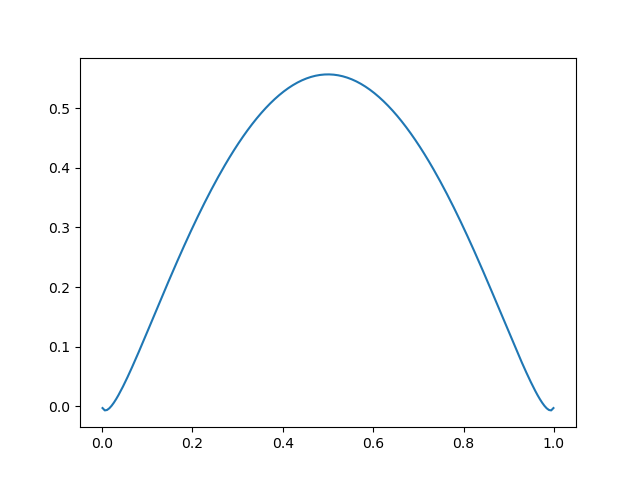

In [75]:
# Compute the chemical potential df/dc
a = 6. / 4
b = 0.2
cc = 5

a = 5. # 6. / 4
b = 0. # 0.2
cc = 0 # 5

free_energy = lambda u, log, sin: u * log(u) + (1-u) * log(1-u) + a * u * (1 - u) + b * sin(cc * np.pi * u)

fig, ax = plt.subplots()

eps = 1e-3

c_plot = np.linspace(eps, 1-eps, 200)

ax.plot(c_plot, free_energy(c_plot, np.log, np.sin))

plt.show()

In [76]:
# Experimental setup
# ------------------

# charging current
I_charge = dfx.fem.Constant(mesh, 1.0)

coords = ufl.SpatialCoordinate(mesh)
r2 = ufl.dot(coords, coords)

y, mu = u.split()
c = c_of_y(y)

c_bc_form = dfx.fem.form(r2 * c * ufl.ds)

def experiment(t, u, I_charge, **kwargs):

    return charge_discharge_stop(t, u, I_charge, c_bc_form, c_of_y=lambda y: c_of_y(y))

event_params = dict(I_charge=I_charge)

In [77]:
# The variational form
# --------------------

params = dict(I_charge=I_charge)

F = cahn_hilliard_form(
    u,
    u0,
    dt,
    free_energy=lambda c: free_energy(c, ufl.ln, ufl.sin),
    theta=0.75,
    c_of_y=c_of_y,
    M=lambda c: 1. * c * (1 - c),
    lam=0.1,
    **params
)

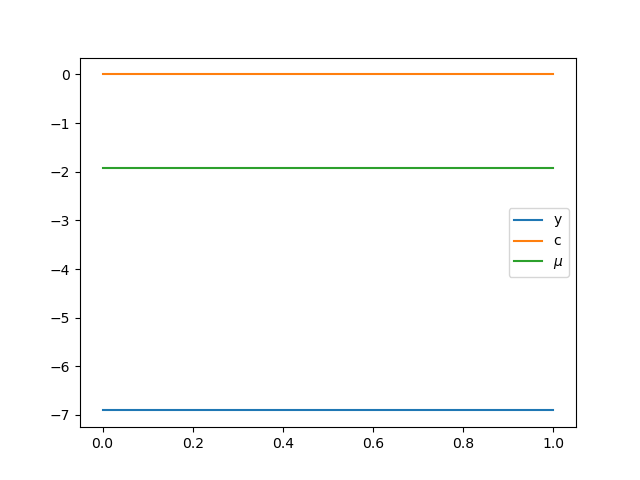

In [78]:
# Initial data
# ------------

u_ini = dfx.fem.Function(V)

# Constant
c_ini_fun = lambda x: eps * np.ones_like(x[0])

# Initial charge distribution.
# c_ini_fun = lambda x: eps + 0.5 * np.sin(np.pi * x[0])

populate_initial_data(u_ini, c_ini_fun, lambda c: free_energy(c, ufl.ln, ufl.sin))

W, _ = V.sub(0).collapse()

c = dfx.fem.Function(W)
c.interpolate(dfx.fem.Expression(c_of_y(u_ini.sub(0)), W.element.interpolation_points()))

plt.figure()

plt.plot(x, u_ini.sub(0).eval(points_on_proc, cells), label="y")
plt.plot(x, c.eval(points_on_proc, cells), label="c")
plt.plot(x, u_ini.sub(1).eval(points_on_proc, cells), label=r"$\mu$")

plt.legend()

plt.show()

In [79]:
problem = NonlinearProblem(F, u)

solver = NewtonSolver(comm_world, problem)

In [80]:
u.interpolate(u_ini)

n_out = 501

output = Fenicx1DOutput(u, np.linspace(0, T, n_out), x)

rt_analysis = AnalyzeOCP(u, c_of_y = lambda y: c_of_y(y))

time_stepping(
    solver,
    u,
    u0,
    T,
    dt,
    dt_increase=1.0,
    dt_max=1e-3,
    event_handler=experiment,
    output=output,
    runtime_analysis=rt_analysis,
    **event_params,
)

TypeError: charge_discharge_stop() missing 1 required positional argument: 'c_bc_form'

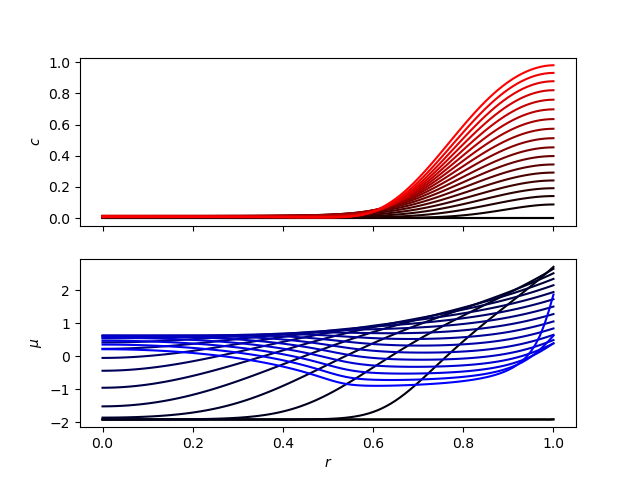

In [ ]:
fig, ax = plot_time_sequence(output, lambda y: np.exp(y) / (np.exp(y) + 1))

plt.show()

interactive(children=(IntSlider(value=0, description='it', max=18), Output()), _dom_classes=('widget-interact'…

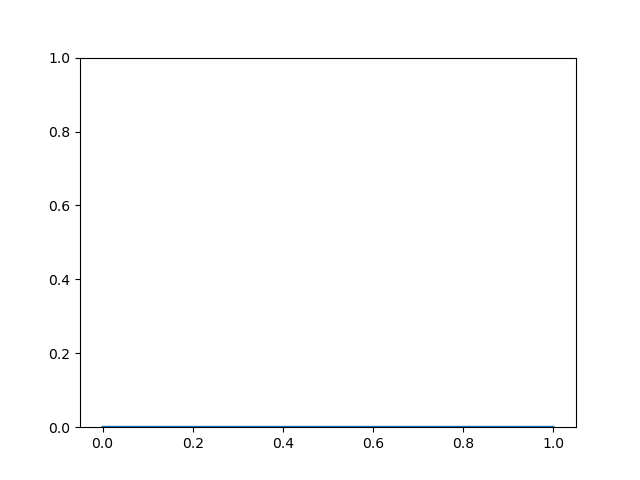

In [ ]:
animate_time_series(output, lambda y: np.exp(y) / (np.exp(y) + 1))

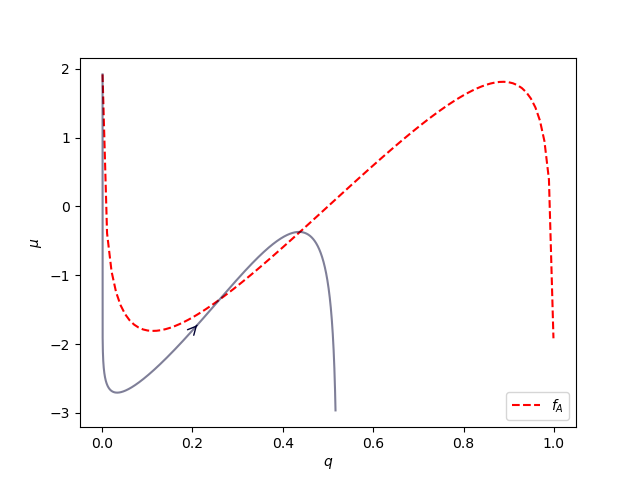

In [ ]:
q, f_bar, mu_bc = np.array(rt_analysis.data).T
t = rt_analysis.t

dFdc = lambda q_plot: np.log(q_plot / (1 - q_plot)) + a * (1 - 2 * q_plot)

ax = plot_charging_cycle([(I_charge.value, q, mu_bc)], dFdc, eps)

fig.savefig("pp_output/CH_2_min_charging_cycle.pdf")

plt.show()